# Import Libraries #

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

/home/anne/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#Import Data#

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [3]:

len (df_test.columns)

80

#Define Median Absolute Deviation Function#

Function found in this link: http://stackoverflow.com/a/22357811/5082694

In [4]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

# Remove Skew from SalesPrice data#

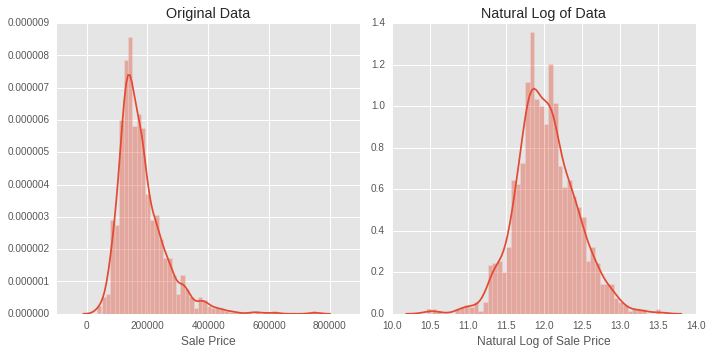

In [5]:
target = df_train[df_train.columns.values[-1]]
target_log = np.log(target)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

# Merge Train and Test to evaluate ranges and missing values #
This was done primarily to ensure that Categorical data in the training and testing data sets were consistent.

In [6]:
df_train = df_train[df_train.columns.values[:-1]]
df = df_train.append(df_test, ignore_index = True)

#Find all categorical data#

In [7]:
cats = []
for col in df.columns.values:
    if df[col].dtype == 'object':
        cats.append(col)

# Create separte datasets for Continuous vs Categorical #
Creating two data sets allowed me to handle the data in more appropriate ways.

In [8]:
df_cont = df.drop(cats, axis=1)
df_cat = df[cats]

# Handle Missing Data for continuous data #

 - If any column contains more than 50 entries of missing data, drop the column
 - If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column
 - Remove outliers using Median Absolute Deviation
 - Calculate skewness for each variable and if greater than 0.75 transform it
 - Apply the sklearn.Normalizer to each column

In [9]:
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        df_cont[col].iloc[idx] = median

        outliers = np.where(is_outlier(df_cont[col]))
        df_cont[col].iloc[outliers] = median
        
        if skew(df_cont[col]) > 0.75:
            df_cont[col] = np.log(df_cont[col])
            df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)
        
        df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]

/home/anne/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Handle Missing Data for Categorical Data #

 - If any column contains more than 50 entries of missing data, drop the column
 - If any column contains fewer that 50 entries of missing data, replace those values with the 'MIA'
 - Apply the sklearn.LabelEncoder
 - For each categorical variable determine the number of unique values and for each, create a new column that is binary

In [10]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

/home/anne/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/anne/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/anne/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

# Merge Numeric and Categorical Datasets and Create Training and Testing Data #

In [11]:
df_new = df_cont.join(df_cat)

df_train = df_new.iloc[:len(df_train) - 1]
df_train = df_train.join(target_log)

df_test = df_new.iloc[len(df_train) + 1:]

X_train = df_train[df_train.columns.values[1:-1]]
y_train = df_train[df_train.columns.values[-1]]

X_test = df_test[df_test.columns.values[1:]]

In [12]:

len (df_train)

1459

# Create Estimator and Apply Cross Validation #

We can gauge the accuracy of our model by implementing an multi-fold cross validation and outputting the score.  In this case I chose to run 15 iterations and output the score as Root Mean Squared Error.

The results range from ~0.11-0.17 with a mean of ~0.14.

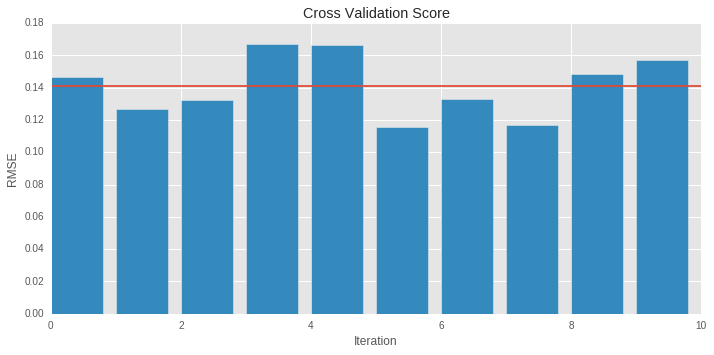

In [13]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
cv_score = np.sqrt(-cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()




In [14]:
print (scorer)

make_scorer(mean_squared_error, greater_is_better=False)


# Evaluate Feature Significance #

Investigating feature importance is a relatively straight forward process:

 1. Out feature importance coefficients
 2. Map coefficients to their feature name
 3. Sort features in descending order

Given our choice of model and methods for preprocessing data the most significant features are:

 1. OverallQual
 2. GrLivArea
 3. TotalBsmtSF
 4. GarageArea

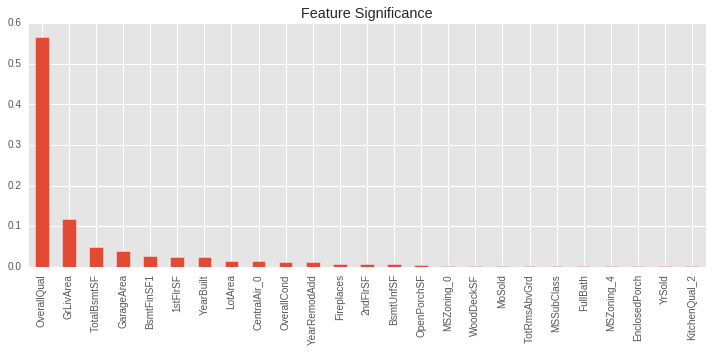

In [15]:
# Fit model with training data
clf.fit(X_train, y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [16]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

In [17]:
import numpy as np 
from sklearn.grid_search import GridSearchCV 
from sklearn.datasets import load_digits 
from sklearn.ensemble import RandomForestRegressor 

clf_grid = RandomForestRegressor(n_jobs=-1) 

param_grid = { "n_estimators" : [250, 300], 
           "max_features" : [3, 5], 
           "max_depth" : [10, 20], 
           "min_samples_split" : [2, 4] , 
           "bootstrap": [True, False]} 
grid_search = GridSearchCV(clf_grid, param_grid, n_jobs=-1, cv=2) 
grid_search.fit(X_train1,y_train1) 
print (grid_search.best_params_)

/home/anne/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'min_samples_split': 2, 'max_features': 5, 'bootstrap': False, 'n_estimators': 300, 'max_depth': 20}


In [18]:
from sklearn.metrics import mean_squared_error 

clf = RandomForestRegressor(n_jobs=-1) 
clf.fit(X_train1, y_train1) 
y_pred = clf.predict(X_test1) 
print('mean_squared_error random forests non optimisé : ' + str(mean_squared_error(y_pred,y_test1))) 

clf = RandomForestRegressor(max_depth= 20, min_samples_split = 2, bootstrap = False, n_estimators = 250, max_features=5,n_jobs=-1) 
clf.fit(X_train1, y_train1) 
y_pred = clf.predict(X_test1) 
print('mean_squared_error random forests optimisé : ' + str(mean_squared_error(y_pred,y_test1)))

mean_squared_error random forests non optimisé : 0.0238854508563
mean_squared_error random forests optimisé : 0.0266952506074


# Visualize Predicted vs. Actual Sales Price #

In order to visualize our predicted values vs our actual values we need to split our data into training and testing data sets.  This can easily be accomplished using sklearn's **train_test_split** module.

We will train the model using a random sampling of our data set and then compare visually against the actual values.

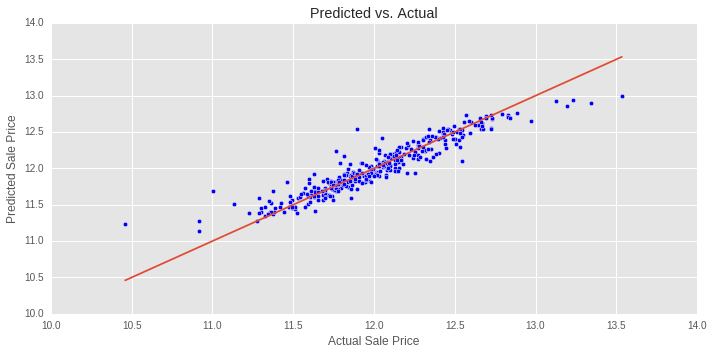

In [19]:
from sklearn.cross_validation import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)
clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [20]:
price = df_train['SalePrice']
print (price.describe()) 

count    1459.000000
mean       12.024135
std         0.399576
min        10.460242
25%        11.774905
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


In [21]:
year_price_2007 = df_train.loc[df_train['YrSold'] == 2007]
price_2007=year_price_2007['SalePrice']
print(2007)
price_2007.describe()

2007


count    329.000000
mean      12.050668
std        0.396504
min       10.578980
25%       11.774520
50%       12.025749
75%       12.299108
max       13.534473
Name: SalePrice, dtype: float64

In [22]:
year_price_2008 = df_train.loc[df_train['YrSold'] == 2008]
price_2008=year_price_2008['SalePrice']
print(2008)
price_2008.describe()

2008


count    303.000000
mean      12.014577
std        0.381223
min       10.596635
25%       11.782945
50%       12.013701
75%       12.240474
max       13.008659
Name: SalePrice, dtype: float64

In [23]:
year_price_2009 = df_train.loc[df_train['YrSold'] == 2009]
price_2009=year_price_2009['SalePrice']
print(2009)
price_2009.describe()

2009


count    338.000000
mean      12.008737
std        0.420303
min       10.460242
25%       11.738061
50%       11.995352
75%       12.267871
max       13.275828
Name: SalePrice, dtype: float64

In [24]:
year_price_2010 = df_train.loc[df_train['YrSold'] == 2010]
price_2010=year_price_2010['SalePrice']
print(2010)
price_2010.describe()

2010


count    175.000000
mean      12.001072
std        0.406821
min       10.915088
25%       11.760566
50%       11.951180
75%       12.270220
max       13.323927
Name: SalePrice, dtype: float64

In [25]:
from sklearn import neighbors 

n_neighbors = 5 

for i, weights in enumerate(['uniform', 'distance']): 
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights) 
    res = knn.fit(X_train1, y_train1).predict(X_test1)

In [33]:
(mean_squared_error(res,y_test1))

0.0723725271290247

In [34]:
from sklearn import linear_model  
regr = linear_model.LinearRegression()  
regr.fit(X_train1.values,y_train1)  
 res2= regr.predict(X_test1)

array([ 11.81520564,  12.28740425,  12.41989642,  11.51637852,
        12.46275296,  12.38294367,  11.76238971,  11.8015382 ,
        12.37336559,  11.77040163,  12.34351674,  12.73966891,
        12.76699402,  13.00472405,  11.45206023,  12.10053872,
        11.853448  ,  12.58587768,  12.13581061,  12.28421282,
        11.76700564,  11.80012193,  12.74480267,  11.8272751 ,
        11.82569792,  11.52826121,  11.5535047 ,  12.04377602,
        12.61433097,  12.47256305,  12.14032596,  12.12984883,
        11.67210029,  11.49405608,  12.23543747,  11.54727287,
        12.16762618,  11.75630896,  12.71564356,  11.70667632,
        11.75773213,  11.72458482,  11.44507005,  11.85230333,
        12.51931162,  11.80008932,  12.81482648,  11.86721424,
        11.70363324,  11.62035192,  12.15530832,  11.98206294,
        12.82211229,  11.88190483,  12.11135879,  11.93146486,
        11.41258702,  12.47959343,  11.7135559 ,  11.71014858,
        11.91604893,  12.06984202,  11.86619209,  12.24

In [35]:
(mean_squared_error(res,y_test1))

0.0723725271290247